In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [3]:
train_dataset = datasets.ImageFolder(root='datasetji', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [4]:
model2 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

In [5]:
for param in model2.parameters():
    param.requires_grad = False

In [6]:
num_ftrs = model2.fc.in_features
model2.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)  # 2 classes: benign and malignant
)

In [7]:
for param in model2.fc.parameters():
    param.requires_grad = True

In [8]:
device = torch.device('cuda')

In [9]:
model2 = model2.to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.fc.parameters(), lr=0.001)

In [11]:
num_epochs = 15
train_loss_hist = []
train_acc_hist = []

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    epoch_precision = precision_score(all_labels, all_preds, average='binary')
    epoch_recall = recall_score(all_labels, all_preds, average='binary')
    epoch_f1 = f1_score(all_labels, all_preds, average='binary')

    train_loss_hist.append(epoch_loss)
    train_acc_hist.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {epoch_loss:.4f} "
          f"Accuracy: {epoch_acc:.4f} "
          f"Precision: {epoch_precision:.4f} "
          f"Recall: {epoch_recall:.4f} "
          f"F1 Score: {epoch_f1:.4f}")


Epoch [1/15] Loss: 0.6916 Accuracy: 0.6187 Precision: 0.4907 Recall: 0.2750 F1 Score: 0.3525
Epoch [2/15] Loss: 0.6043 Accuracy: 0.6737 Precision: 0.6305 Recall: 0.3271 F1 Score: 0.4307
Epoch [3/15] Loss: 0.5665 Accuracy: 0.7026 Precision: 0.6445 Recall: 0.4722 F1 Score: 0.5451
Epoch [4/15] Loss: 0.5449 Accuracy: 0.7188 Precision: 0.6780 Recall: 0.4854 F1 Score: 0.5658
Epoch [5/15] Loss: 0.5320 Accuracy: 0.7290 Precision: 0.6915 Recall: 0.5090 F1 Score: 0.5864
Epoch [6/15] Loss: 0.5230 Accuracy: 0.7393 Precision: 0.7017 Recall: 0.5375 F1 Score: 0.6087
Epoch [7/15] Loss: 0.4915 Accuracy: 0.7657 Precision: 0.7366 Recall: 0.5903 F1 Score: 0.6554
Epoch [8/15] Loss: 0.5118 Accuracy: 0.7458 Precision: 0.7129 Recall: 0.5465 F1 Score: 0.6187
Epoch [9/15] Loss: 0.4911 Accuracy: 0.7628 Precision: 0.7412 Recall: 0.5708 F1 Score: 0.6450
Epoch [10/15] Loss: 0.4752 Accuracy: 0.7607 Precision: 0.7305 Recall: 0.5799 F1 Score: 0.6465
Epoch [11/15] Loss: 0.4639 Accuracy: 0.7704 Precision: 0.7331 Recall:

In [13]:
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))




<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

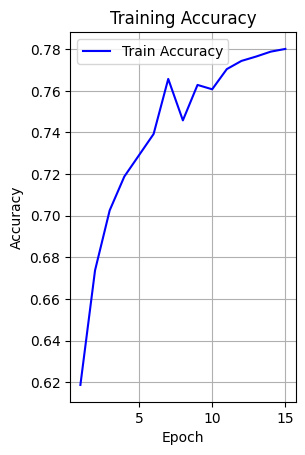

In [14]:
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc_hist, label='Train Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.grid(True)
plt.legend()

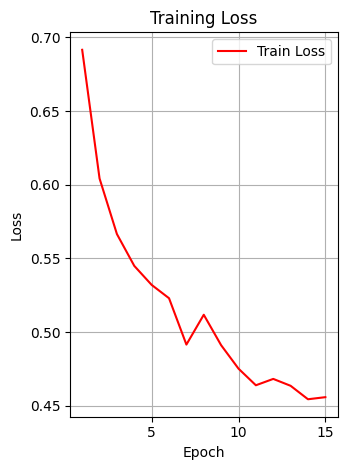

In [15]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_hist, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms

# 1. Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 2. Load the entire dataset
full_dataset = datasets.ImageFolder(root='datasetji', transform=transform)

# 3. Split into train and validation
train_size = int(0.8 * len(full_dataset))  # 80% for training
val_size = len(full_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 4. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)   # <-- Now you have val_loader ✅


In [17]:
# Assuming you have your validation dataloader (val_loader) ready
import torch

def get_predictions(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

# Example Usage:
# Make sure model is your trained model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# y_true, y_pred = get_predictions(model, val_loader, device)


In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_conf_matrix(y_true, y_pred, class_names=['Benign', 'Malignant']):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# After getting predictions:
# plot_conf_matrix(y_true, y_pred)


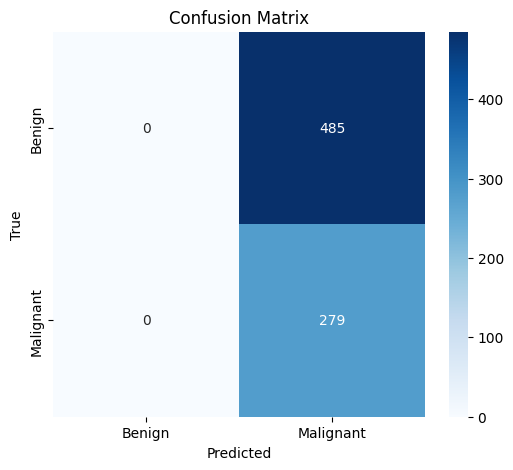

In [19]:
y_true, y_pred = get_predictions(model2, val_loader, device)
plot_conf_matrix(y_true, y_pred)
